In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# product group and starting date

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [48]:
from bktest.backtest_grid_search import *

df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2023,1,20),
    roll_name='expiry',
    sim_markets=all_markets,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
    
print(df.tail(10))


product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-01-09  8431.0   AP2305   1797.0  2023-05-17  8623.0  8383.0  24281.0   
2023-01-10  8440.0   AP2305 -10080.0  2023-05-17  8454.0  8365.0  24281.0   
2023-01-11  8475.0   AP2305   5503.0  2023-05-17  8519.0  8407.0  24281.0   
2023-01-12  8482.0   AP2305    281.0  2023-05-17  8593.0  8425.0  24281.0   
2023-01-13  8786.0   AP2305  20292.0  2023-05-17  8795.0  8474.0  24281.0   
2023-01-16  8610.0   AP2305 -15788.0  2023-05-17  8785.0  8567.0  24281.0   
2023-01-17  8558.0   AP2305  -8904.0  2023-05-17  8677.0  8538.0  24281.0   
2023-01-18  8576.0   AP2305  -2695.0  2023-05-17  8630.0  8520.0  24281.0   
2023-01-19  8623.0   AP2305   2722.0  2023-05-17  8655.0  8416.0  24281.0   

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


# strategy portfolio config

In [8]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite2 = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#         ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#         ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#         ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#         ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#         ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


rebal = 1
ma_win = 122
scenarios_test = [
    ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
]

In [40]:
product_grouping = {
    'ind': ['rb', 'hc', 'i', 'j', 'jm', 'FG', 'SM', "SF", 'SA', 'UR', 'cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss'],
    'petro': ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF', 'ru', 'nr', 'CF', 'SR'],
    'ags': ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK'],
}

# ferrous_group = ['rb', 'hc', 'i', 'j', 'jm', 'FG', 'SM', "SF", 'SA', 'UR']
# metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss', 'au', 'ag']
# petro_group = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF', 'ru', 'nr', 'CY', 'CF', 'SR', ] 
# ags_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK',]


# run backtest for a portfolio group

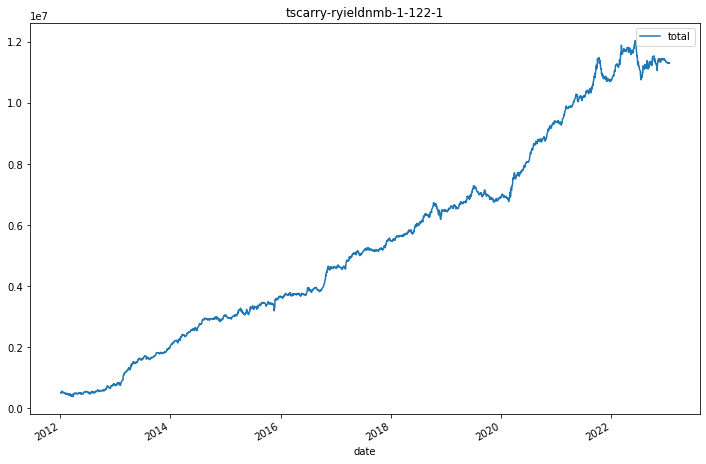

       sharpe       std  sortino
tenor                           
all      1.86  32454.72     2.76
6m       1.09  53992.59     1.83
1y       0.36  59685.52     0.57
2y       1.19  53326.34     1.85
3y       1.92  48785.12     2.94
4y       1.71  44641.43     2.67
5y       1.74  42633.64     2.66
6y       1.78  40004.68     2.70
7y       1.83  38341.99     2.77
8y       1.78  37504.53     2.72
9y       1.81  36041.48     2.74
10y      1.94  34811.20     2.90
11y      1.88  33571.60     2.80


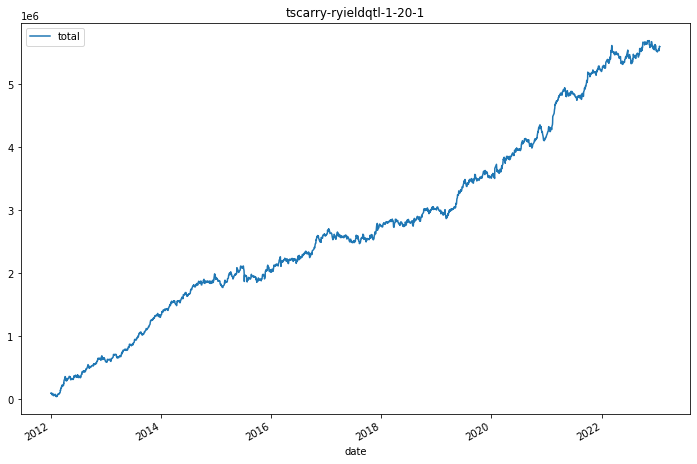

       sharpe       std  sortino
tenor                           
all      1.66  17964.72     2.51
6m       1.35  22642.00     2.20
1y       0.95  23024.13     1.54
2y       1.87  22248.13     3.11
3y       1.99  22260.15     3.41
4y       1.96  21307.22     3.43
5y       1.74  20704.78     3.03
6y       1.53  20288.71     2.59
7y       1.60  20057.48     2.60
8y       1.48  20133.39     2.32
9y       1.52  19561.80     2.38
10y      1.69  18905.59     2.60
11y      1.75  18430.28     2.69


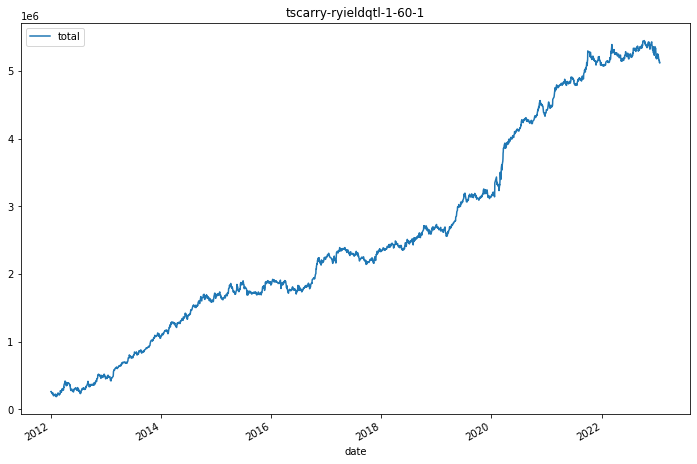

       sharpe       std  sortino
tenor                           
all      1.48  18444.04     2.28
6m      -0.46  25285.15    -0.69
1y       0.10  23235.11     0.16
2y       0.89  22616.22     1.49
3y       1.71  24544.09     2.91
4y       1.72  22988.16     2.90
5y       1.59  22222.76     2.63
6y       1.42  21353.66     2.32
7y       1.40  21078.26     2.23
8y       1.33  20670.84     2.13
9y       1.41  20133.88     2.25
10y      1.53  19455.68     2.39
11y      1.51  19058.91     2.35


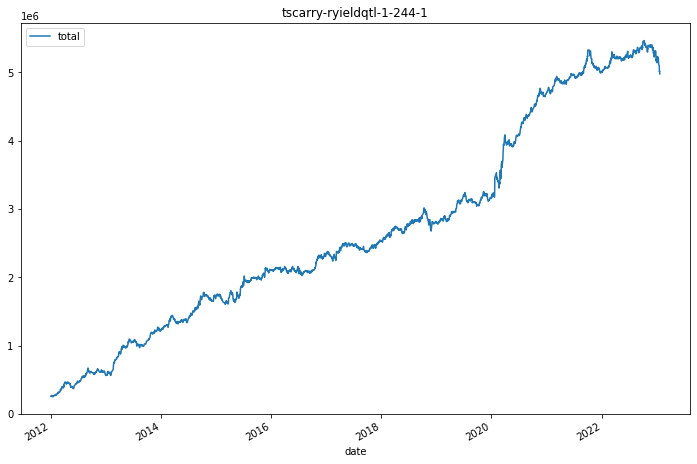

       sharpe       std  sortino
tenor                           
all      1.51  17609.53     2.36
6m      -1.11  26646.34    -1.60
1y      -0.23  22702.29    -0.33
2y       0.38  20581.75     0.56
3y       1.54  24820.22     2.45
4y       1.53  22696.95     2.42
5y       1.41  21879.34     2.21
6y       1.35  20745.38     2.13
7y       1.31  20047.58     2.05
8y       1.31  19810.92     2.07
9y       1.37  19304.69     2.18
10y      1.50  18779.42     2.38
11y      1.51  18191.59     2.39


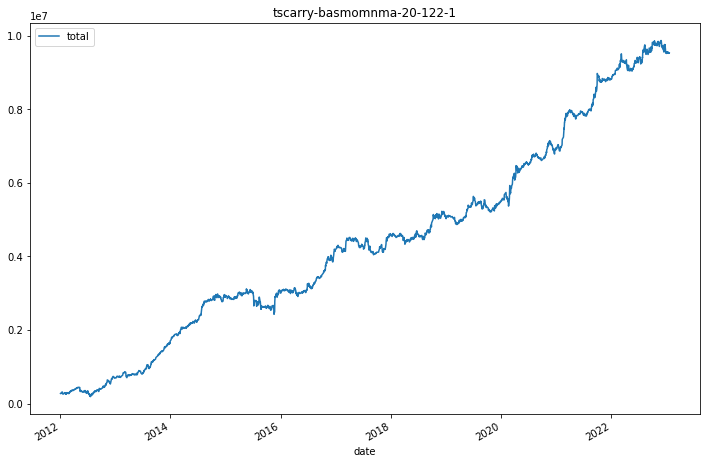

       sharpe       std  sortino
tenor                           
all      1.55  32801.24     2.22
6m       0.62  48551.93     1.00
1y       0.82  46016.42     1.31
2y       1.88  43917.45     3.12
3y       1.92  44259.01     2.92
4y       1.73  40870.95     2.65
5y       1.60  39725.23     2.46
6y       1.47  38318.06     2.25
7y       1.59  37210.94     2.44
8y       1.40  37757.66     2.12
9y       1.51  36355.05     2.27
10y      1.62  34935.78     2.38
11y      1.61  33691.61     2.34


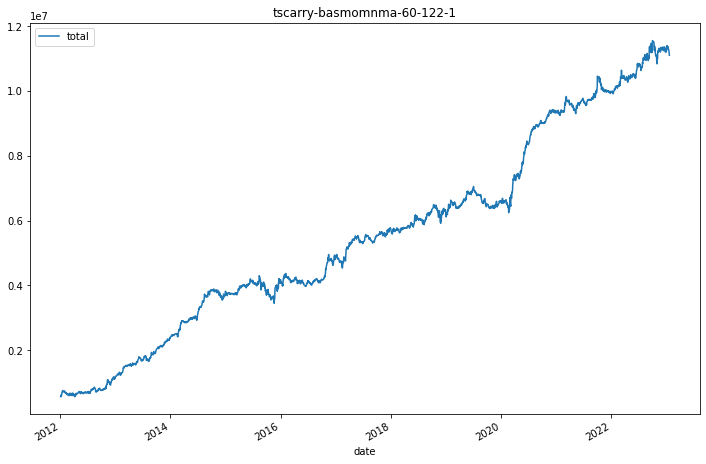

       sharpe       std  sortino
tenor                           
all      1.47  40217.36     2.17
6m       0.69  71978.93     1.24
1y       1.13  61520.90     1.95
2y       1.07  53691.79     1.77
3y       1.81  53218.73     2.94
4y       1.50  49242.56     2.42
5y       1.41  48590.73     2.16
6y       1.45  46406.40     2.22
7y       1.41  44898.83     2.16
8y       1.29  45646.01     1.94
9y       1.38  44362.54     2.08
10y      1.48  42736.15     2.20
11y      1.47  41320.77     2.17


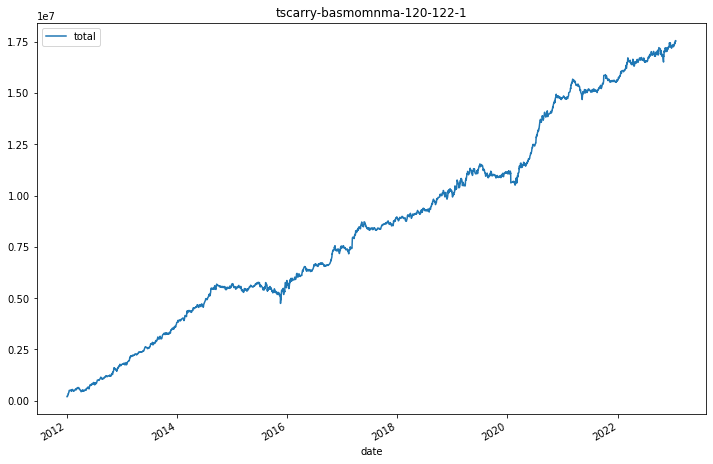

       sharpe       std  sortino
tenor                           
all      1.82  51491.31     2.59
6m       1.43  76841.40     2.48
1y       1.50  68558.74     2.42
2y       1.48  60736.18     2.36
3y       2.13  64009.69     2.98
4y       1.78  63543.24     2.62
5y       1.79  61917.00     2.60
6y       1.83  59286.48     2.68
7y       1.87  57309.49     2.75
8y       1.63  58793.55     2.37
9y       1.70  56972.71     2.48
10y      1.84  54973.28     2.65
11y      1.87  53107.87     2.69


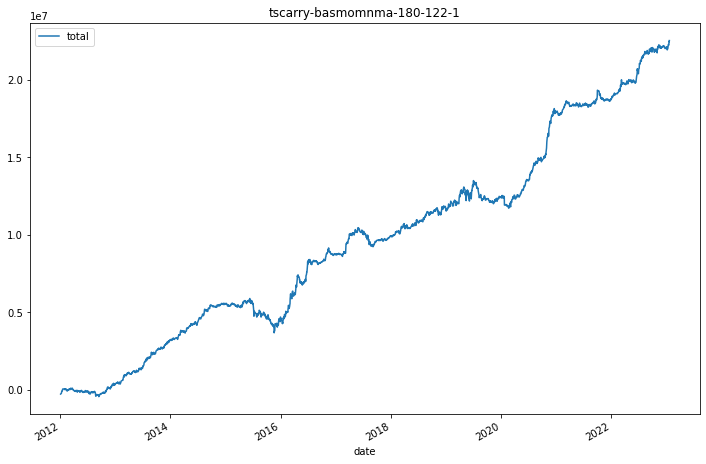

       sharpe       std  sortino
tenor                           
all      1.78  67500.93     2.64
6m       1.98  74440.93     3.30
1y       2.96  75388.44     5.13
2y       2.32  66213.85     4.06
3y       2.93  73280.11     4.47
4y       2.13  79439.34     3.28
5y       2.09  77066.51     3.17
6y       1.98  74410.44     2.99
7y       2.14  76524.68     3.37
8y       1.76  77658.72     2.70
9y       1.83  74532.10     2.80
10y      1.97  72046.28     2.99
11y      1.89  69582.01     2.85


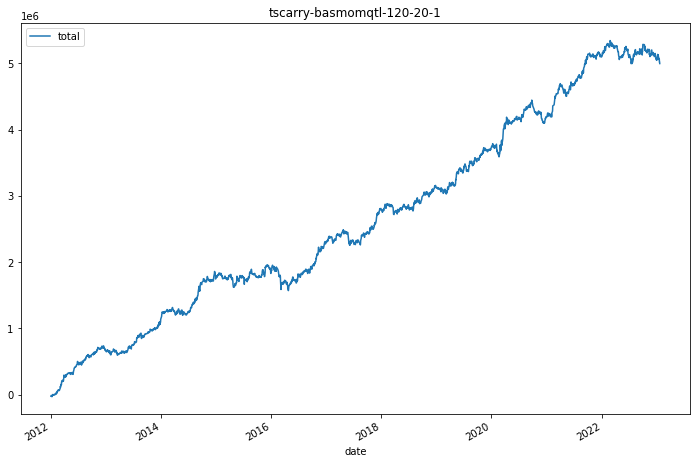

       sharpe       std  sortino
tenor                           
all      1.44  18557.54     2.12
6m      -0.07  26064.92    -0.10
1y      -0.57  23931.31    -0.89
2y       1.09  22340.56     1.71
3y       1.16  22836.11     1.79
4y       1.39  21847.66     2.23
5y       1.34  21052.01     2.14
6y       1.38  20447.62     2.16
7y       1.37  20661.80     2.06
8y       1.24  20448.92     1.86
9y       1.33  20081.84     2.00
10y      1.42  19574.10     2.13
11y      1.54  19006.08     2.29


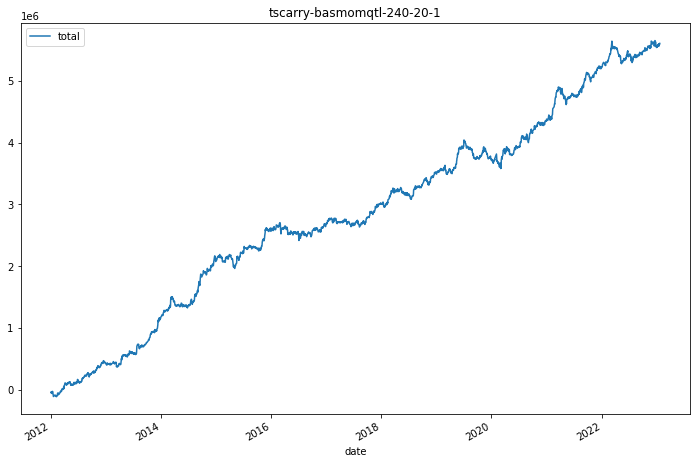

       sharpe       std  sortino
tenor                           
all      1.66  17998.84     2.56
6m       1.72  20161.30     2.75
1y       1.00  21115.46     1.65
2y       1.83  20851.80     2.90
3y       1.90  21494.83     2.99
4y       1.60  20744.19     2.60
5y       1.70  20025.57     2.79
6y       1.58  19279.99     2.55
7y       1.42  19395.33     2.19
8y       1.44  19140.16     2.25
9y       1.62  19183.46     2.56
10y      1.77  18827.75     2.81
11y      1.81  18348.67     2.87


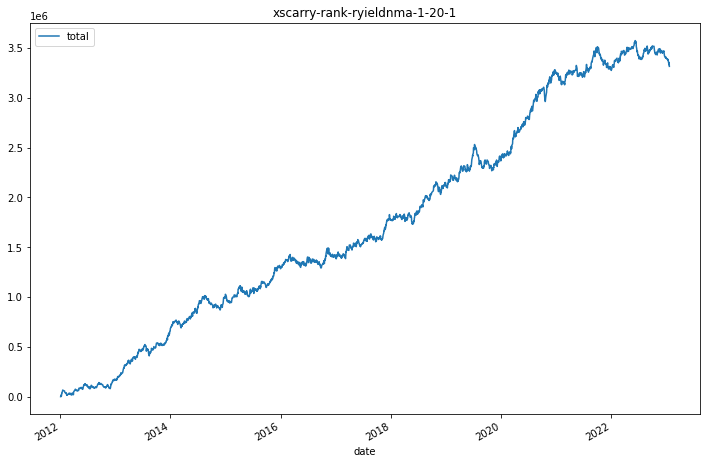

       sharpe       std  sortino
tenor                           
all      1.44  12298.72     2.26
6m      -0.68  12658.97    -1.01
1y      -0.11  13180.84    -0.17
2y       0.30  14016.35     0.47
3y       1.32  14756.10     2.10
4y       1.23  14859.75     2.07
5y       1.33  14517.64     2.18
6y       1.43  14094.90     2.34
7y       1.29  14143.11     2.10
8y       1.36  13920.80     2.22
9y       1.35  13563.96     2.20
10y      1.52  13210.43     2.45
11y      1.49  12738.22     2.37


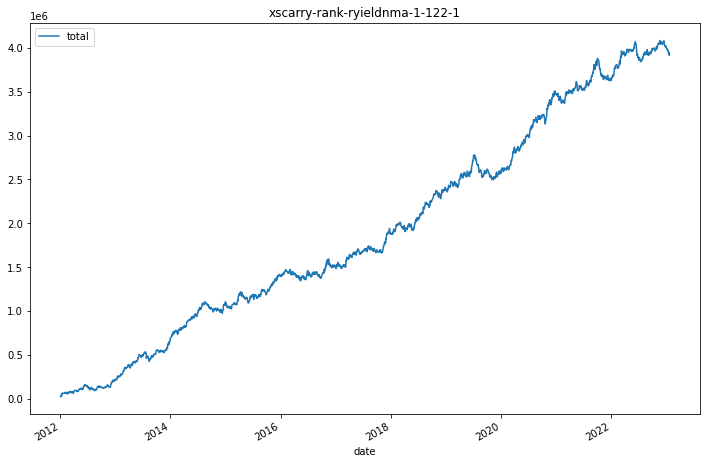

       sharpe       std  sortino
tenor                           
all      1.72  12160.91     2.73
6m       0.68  12242.58     0.99
1y       0.86  14262.92     1.26
2y       1.10  14725.26     1.68
3y       1.89  14902.91     3.08
4y       1.60  14862.30     2.77
5y       1.75  14557.54     2.96
6y       1.81  14110.83     3.02
7y       1.62  14119.21     2.71
8y       1.66  13834.53     2.77
9y       1.68  13447.93     2.79
10y      1.80  13091.47     2.95
11y      1.79  12619.69     2.87


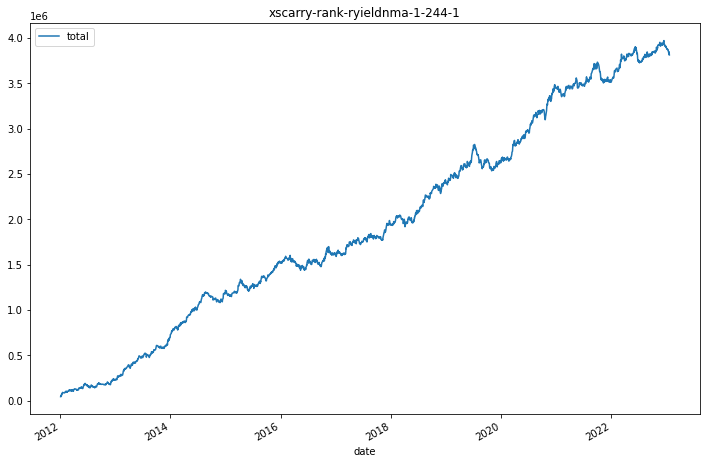

       sharpe       std  sortino
tenor                           
all      1.73  11754.31     2.73
6m       0.71  12562.58     1.10
1y       0.97  14182.72     1.55
2y       0.90  14254.02     1.40
3y       1.72  14409.45     2.81
4y       1.50  14491.37     2.60
5y       1.65  14336.52     2.76
6y       1.68  13846.89     2.78
7y       1.50  13871.18     2.51
8y       1.57  13495.80     2.60
9y       1.65  13055.63     2.72
10y      1.80  12650.60     2.93
11y      1.78  12185.07     2.85


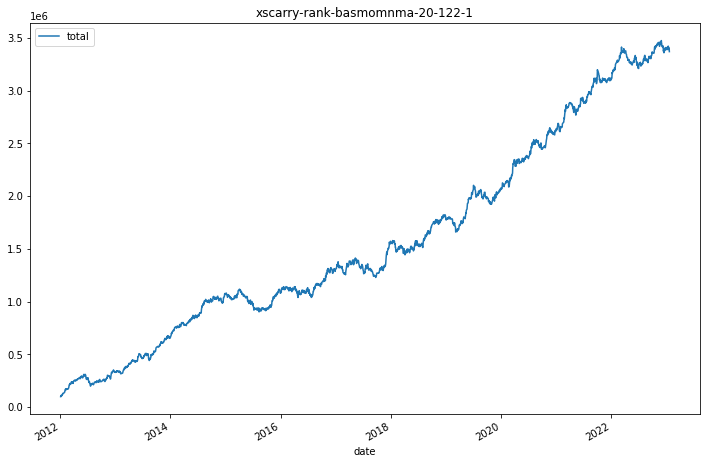

       sharpe       std  sortino
tenor                           
all      1.65  10882.54     2.53
6m       1.18  12582.07     1.67
1y       0.85  12911.60     1.31
2y       1.69  13596.36     2.58
3y       2.00  13517.80     3.14
4y       1.91  13217.38     3.01
5y       1.77  13126.52     2.75
6y       1.68  12862.66     2.65
7y       1.63  12679.08     2.58
8y       1.50  12344.85     2.38
9y       1.57  11980.95     2.49
10y      1.68  11600.28     2.63
11y      1.69  11230.57     2.62


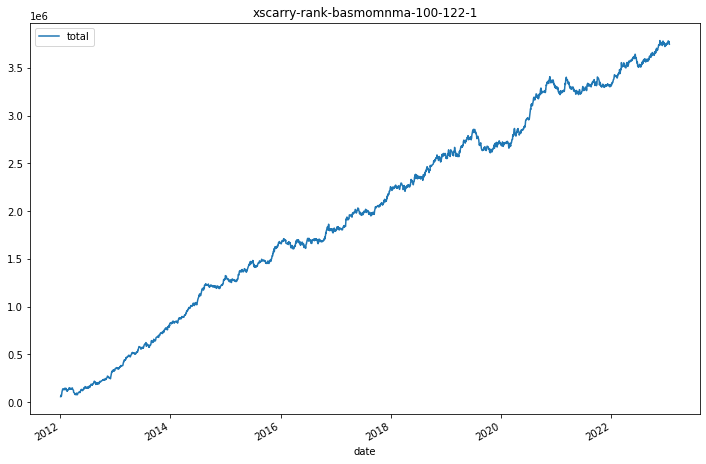

       sharpe       std  sortino
tenor                           
all      1.82  10986.69     2.88
6m       2.07  12977.55     3.62
1y       1.65  13355.76     3.01
2y       1.25  13009.15     2.12
3y       1.67  13349.63     2.90
4y       1.32  13485.40     2.22
5y       1.43  13469.77     2.35
6y       1.59  12972.03     2.63
7y       1.47  12867.24     2.46
8y       1.57  12500.20     2.62
9y       1.71  12055.92     2.81
10y      1.86  11690.74     3.02
11y      1.86  11323.64     2.98


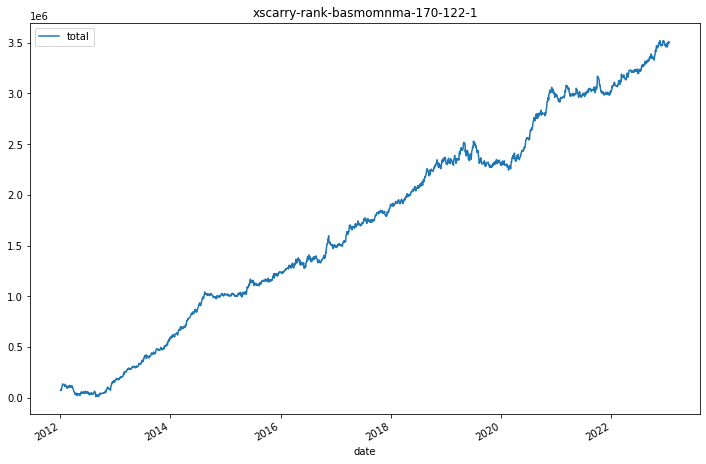

       sharpe       std  sortino
tenor                           
all      1.76  10789.37     2.72
6m       2.61  11721.61     4.73
1y       2.32  11456.45     4.16
2y       1.55  12033.47     2.67
3y       1.99  12631.64     3.36
4y       1.37  13372.09     2.26
5y       1.57  13062.70     2.53
6y       1.70  12553.02     2.75
7y       1.65  12605.57     2.66
8y       1.62  12257.56     2.60
9y       1.74  11810.19     2.76
10y      1.87  11415.76     2.92
11y      1.78  11090.34     2.77


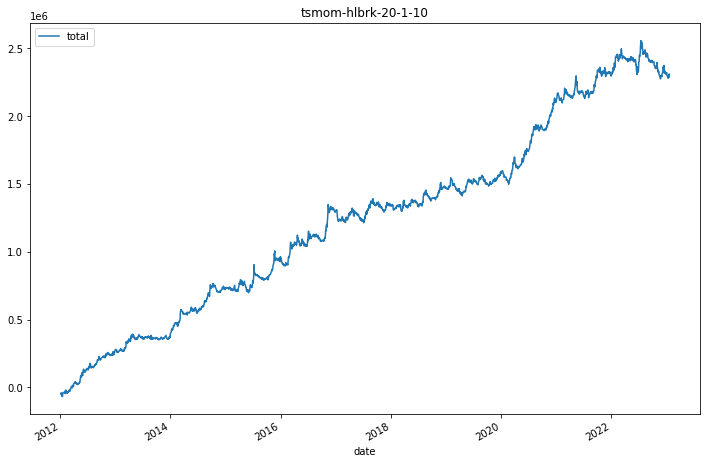

       sharpe       std  sortino
tenor                           
all      1.28   9652.68     1.89
6m      -2.48  11110.37    -3.20
1y      -0.31  13472.55    -0.45
2y       0.41  13009.65     0.61
3y       1.30  12131.12     1.88
4y       1.19  11212.12     1.74
5y       1.20  10692.28     1.77
6y       1.10  10476.96     1.65
7y       1.21  10699.00     1.87
8y       1.18  10758.97     1.76
9y       1.27  10464.54     1.91
10y      1.30  10141.48     1.94
11y      1.39   9879.36     2.08


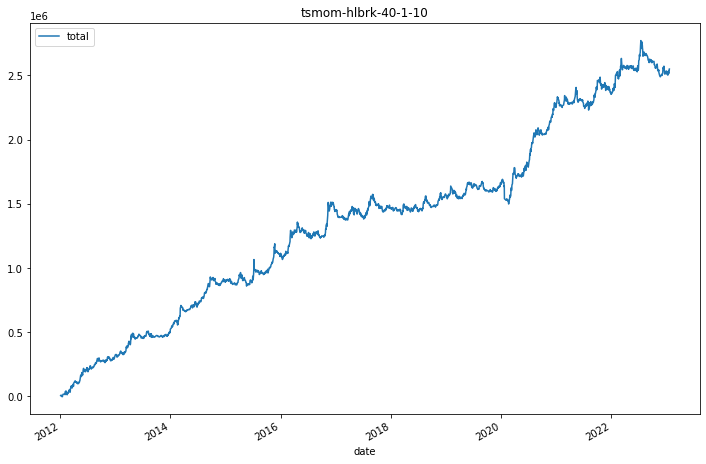

       sharpe       std  sortino
tenor                           
all      1.28  10661.24     1.83
6m      -2.19  11162.04    -2.87
1y       0.57  14568.71     0.87
2y       0.59  13743.28     0.91
3y       1.35  13936.30     1.88
4y       1.23  12724.93     1.72
5y       1.18  11981.19     1.66
6y       1.05  11707.51     1.52
7y       1.13  11823.42     1.69
8y       1.11  11871.15     1.61
9y       1.23  11522.47     1.79
10y      1.28  11199.22     1.86
11y      1.36  10902.27     1.97


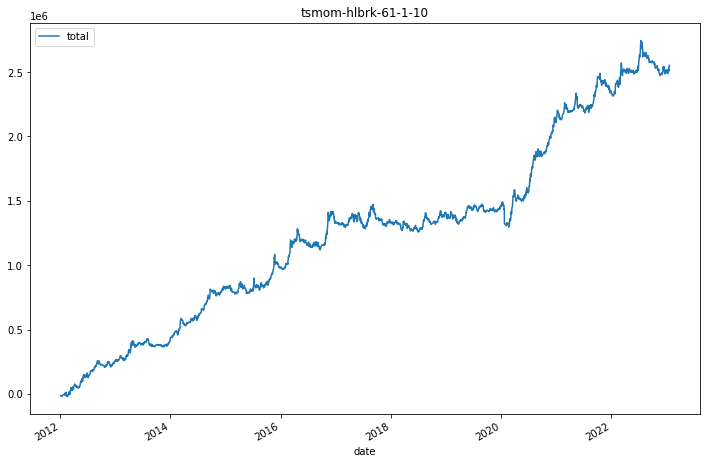

       sharpe       std  sortino
tenor                           
all      1.26  10764.34     1.82
6m      -1.86  11163.74    -2.43
1y       0.94  14908.47     1.40
2y       0.89  13912.20     1.36
3y       1.61  14421.87     2.20
4y       1.44  13102.19     1.96
5y       1.28  12307.65     1.77
6y       1.09  12055.20     1.54
7y       1.20  12107.50     1.76
8y       1.15  11973.81     1.66
9y       1.29  11610.73     1.85
10y      1.30  11283.32     1.87
11y      1.36  10985.75     1.96


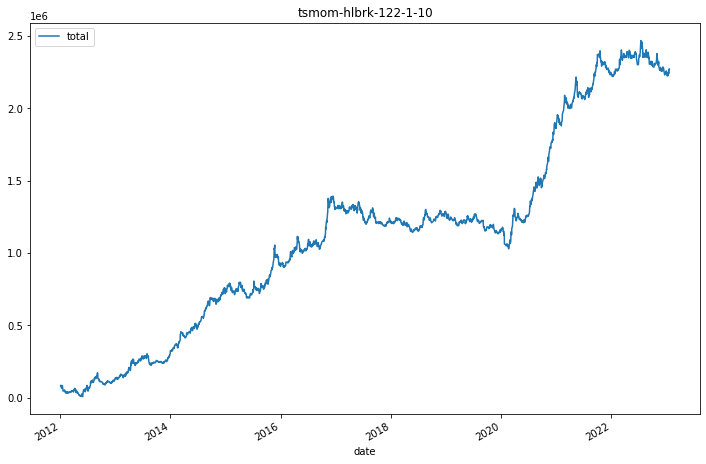

       sharpe       std  sortino
tenor                           
all      1.17  10396.72     1.68
6m      -1.69  12987.22    -2.32
1y       0.16  13728.24     0.23
2y       0.81  13956.16     1.19
3y       1.71  13983.51     2.47
4y       1.30  12626.54     1.87
5y       1.15  11769.33     1.66
6y       0.89  11438.51     1.30
7y       1.09  11538.58     1.62
8y       1.04  11563.91     1.54
9y       1.22  11249.67     1.79
10y      1.26  10925.35     1.83
11y      1.22  10581.90     1.76


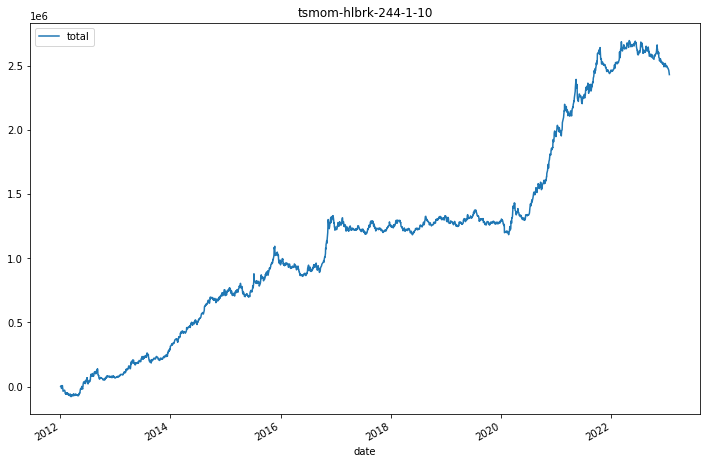

       sharpe       std  sortino
tenor                           
all      1.23  10519.40     1.77
6m      -2.63  11227.72    -3.79
1y      -0.28  12701.82    -0.43
2y       0.92  14905.15     1.41
3y       1.72  14432.47     2.58
4y       1.41  12983.18     2.08
5y       1.25  12033.91     1.83
6y       1.08  11519.18     1.58
7y       1.17  11621.06     1.74
8y       1.14  11801.66     1.69
9y       1.31  11413.11     1.90
10y      1.37  11066.12     1.98
11y      1.33  10771.74     1.92


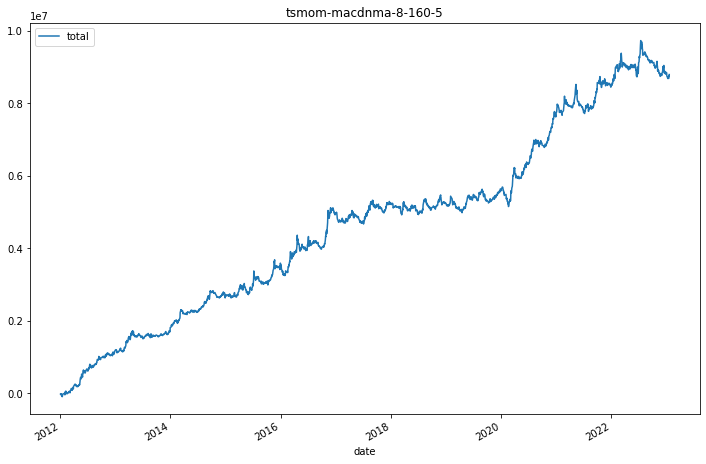

       sharpe       std  sortino
tenor                           
all      1.24  37700.65     1.85
6m      -2.59  40583.07    -3.24
1y       0.05  54674.97     0.08
2y       0.58  51954.29     0.86
3y       1.39  49206.08     2.09
4y       1.28  45149.91     1.91
5y       1.10  42814.77     1.65
6y       1.04  41678.72     1.58
7y       1.19  42756.66     1.85
8y       1.15  42398.05     1.76
9y       1.21  40705.91     1.81
10y      1.25  39491.47     1.86
11y      1.34  38449.57     2.00


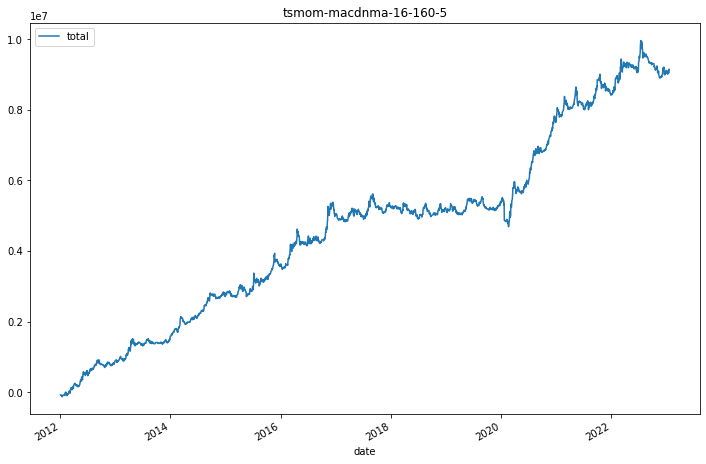

       sharpe       std  sortino
tenor                           
all      1.18  41483.08     1.64
6m      -2.14  42399.37    -2.69
1y       0.60  57170.23     0.90
2y       0.73  54474.08     1.07
3y       1.41  56326.65     1.86
4y       1.26  50833.23     1.66
5y       1.05  47742.85     1.42
6y       0.98  46450.40     1.35
7y       1.09  47201.32     1.55
8y       1.08  46620.92     1.53
9y       1.19  44797.10     1.66
10y      1.22  43487.78     1.70
11y      1.28  42264.15     1.78


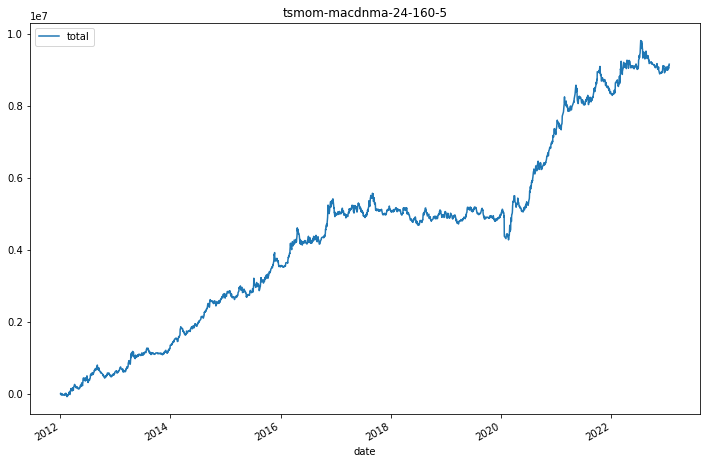

       sharpe       std  sortino
tenor                           
all      1.14  42922.85     1.56
6m      -1.61  45031.58    -2.14
1y       0.84  58776.02     1.23
2y       0.95  56647.55     1.42
3y       1.48  59571.88     1.90
4y       1.27  53484.26     1.63
5y       1.04  50002.21     1.36
6y       0.91  48601.82     1.22
7y       1.05  49038.66     1.45
8y       1.05  48315.42     1.44
9y       1.18  46494.18     1.61
10y      1.22  45077.30     1.65
11y      1.23  43786.07     1.66


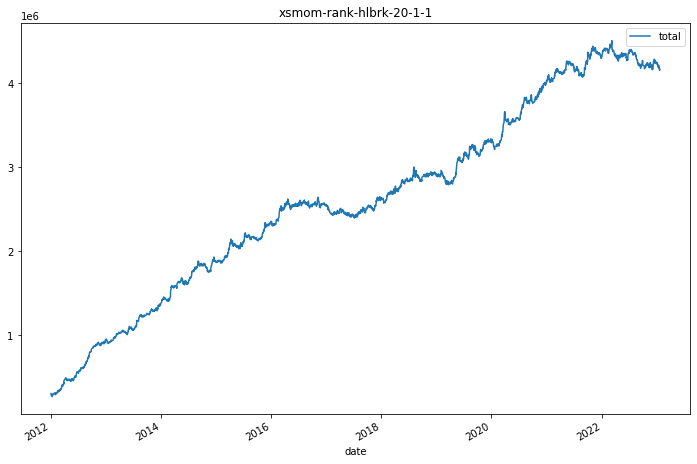

       sharpe       std  sortino
tenor                           
all      1.58  14055.30     2.54
6m      -1.79  15067.47    -2.51
1y      -0.95  16899.41    -1.37
2y       0.20  17497.65     0.33
3y       1.15  17213.87     1.84
4y       1.15  17354.65     1.90
5y       1.19  17054.11     1.97
6y       1.09  16442.51     1.81
7y       1.05  16181.67     1.74
8y       1.15  15809.81     1.91
9y       1.25  15470.40     2.08
10y      1.40  14961.24     2.30
11y      1.55  14527.82     2.53


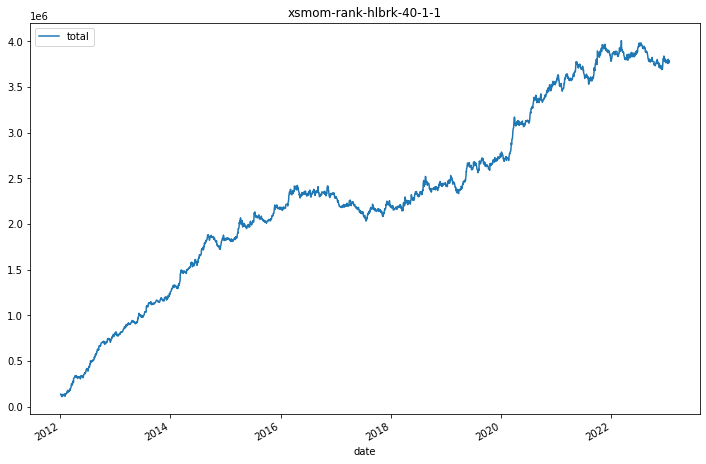

       sharpe       std  sortino
tenor                           
all      1.41  14304.30     2.24
6m      -1.44  15415.46    -1.94
1y      -0.38  17289.00    -0.56
2y       0.37  18286.59     0.62
3y       1.27  17928.96     2.07
4y       1.19  17557.03     1.99
5y       1.20  17350.80     2.01
6y       1.00  16735.46     1.66
7y       0.90  16455.92     1.49
8y       0.97  16035.99     1.60
9y       1.12  15731.93     1.84
10y      1.27  15203.95     2.06
11y      1.45  14785.09     2.33


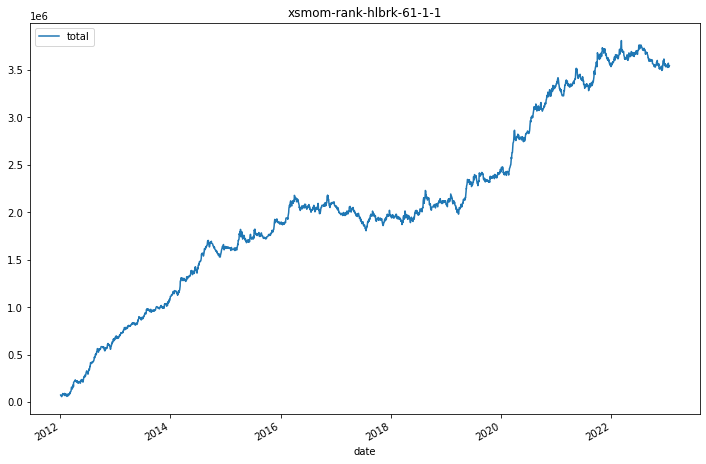

       sharpe       std  sortino
tenor                           
all      1.33  14196.15     2.13
6m      -1.75  14198.44    -2.23
1y      -0.26  16971.03    -0.38
2y       0.36  17870.83     0.60
3y       1.35  17756.25     2.26
4y       1.29  17420.04     2.21
5y       1.19  17164.18     2.01
6y       0.98  16644.36     1.64
7y       0.94  16323.15     1.56
8y       0.96  15955.24     1.59
9y       1.09  15607.10     1.81
10y      1.22  15061.13     1.99
11y      1.38  14675.96     2.23


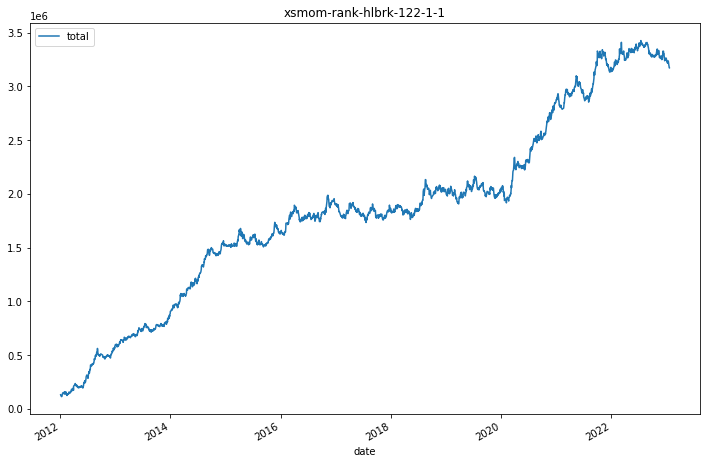

       sharpe       std  sortino
tenor                           
all      1.24  13596.59     1.91
6m      -2.32  12549.41    -3.17
1y      -0.07  16076.32    -0.10
2y       0.59  17026.24     0.95
3y       1.41  17414.53     2.26
4y       1.06  16898.43     1.74
5y       1.03  16440.07     1.66
6y       0.87  15976.60     1.39
7y       0.90  15758.89     1.43
8y       0.86  15364.35     1.37
9y       1.06  14957.76     1.68
10y      1.15  14451.97     1.80
11y      1.26  14065.69     1.96


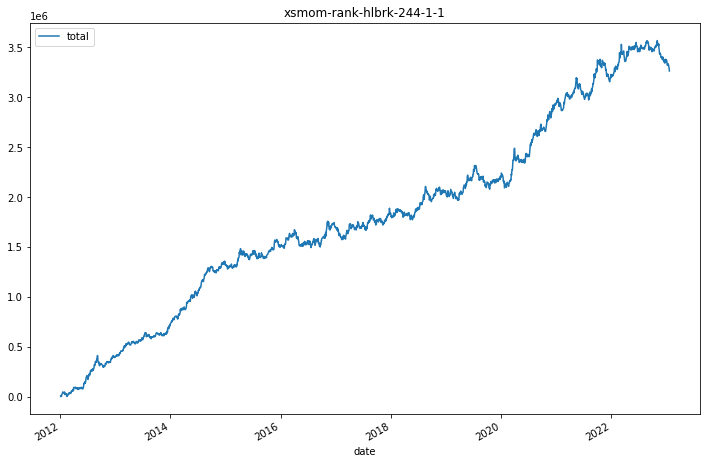

       sharpe       std  sortino
tenor                           
all      1.34  13004.58     2.03
6m      -2.36  12401.19    -3.54
1y       0.03  16368.14     0.04
2y       0.62  16706.46     1.00
3y       1.39  16939.53     2.25
4y       1.19  16362.14     1.98
5y       1.16  15780.67     1.89
6y       1.12  15426.90     1.81
7y       1.06  15255.62     1.69
8y       1.06  14853.09     1.70
9y       1.23  14376.29     1.94
10y      1.32  13869.12     2.04
11y      1.39  13481.18     2.14


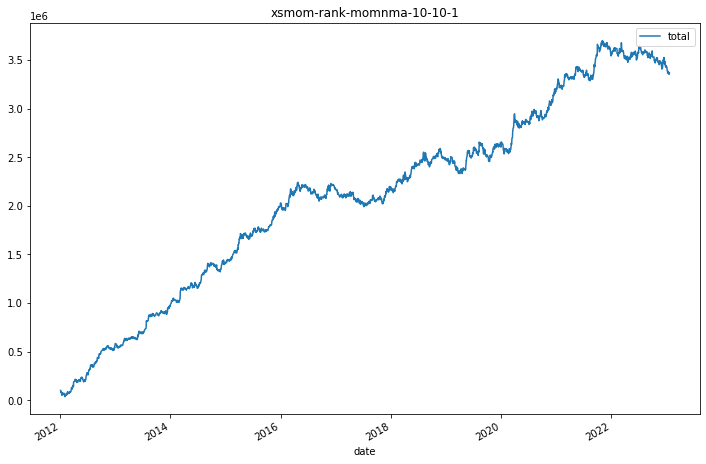

       sharpe       std  sortino
tenor                           
all      1.31  13706.67     2.14
6m      -1.75  15071.96    -2.26
1y      -0.97  16534.30    -1.44
2y       0.19  17228.59     0.31
3y       0.99  17200.16     1.61
4y       0.85  17062.99     1.41
5y       0.92  16720.73     1.55
6y       0.83  16120.70     1.40
7y       0.81  15841.82     1.39
8y       1.00  15452.50     1.70
9y       1.10  15044.15     1.85
10y      1.25  14548.00     2.08
11y      1.36  14156.03     2.25


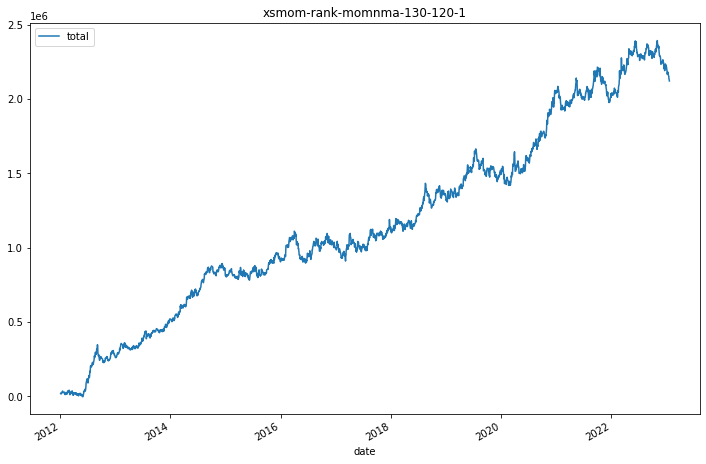

       sharpe       std  sortino
tenor                           
all      0.90  12536.95     1.36
6m      -1.66  12910.66    -2.69
1y       0.29  16357.68     0.46
2y       0.18  15724.42     0.27
3y       0.82  16279.24     1.28
4y       0.76  15701.21     1.22
5y       0.82  15190.86     1.31
6y       0.81  14921.43     1.29
7y       0.75  14739.18     1.18
8y       0.73  14272.35     1.15
9y       0.82  13809.19     1.28
10y      0.89  13326.21     1.35
11y      0.94  12975.08     1.43


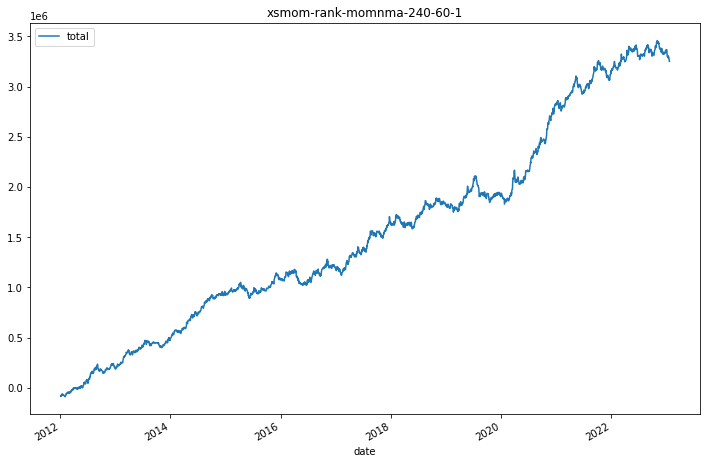

       sharpe       std  sortino
tenor                           
all      1.47  12051.50     2.24
6m      -0.59  13471.53    -0.96
1y       0.11  14587.80     0.17
2y       1.00  14469.83     1.61
3y       1.93  15168.17     3.09
4y       1.55  14871.95     2.51
5y       1.42  14425.50     2.31
6y       1.56  14306.14     2.54
7y       1.42  14047.00     2.30
8y       1.36  13629.86     2.17
9y       1.47  13178.34     2.31
10y      1.53  12757.37     2.37
11y      1.57  12388.40     2.41


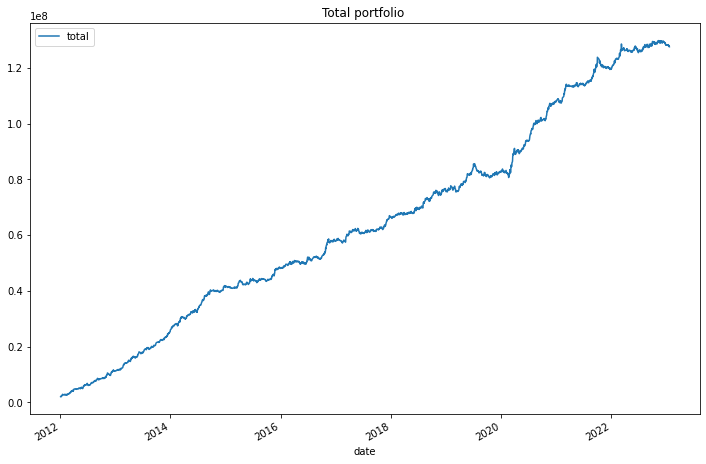

       sharpe        std  sortino
tenor                            
all      2.58  263207.24     4.13
6m       0.62  310430.91     1.09
1y       1.08  343107.91     1.79
2y       1.82  342542.82     3.12
3y       2.69  354702.78     4.56
4y       2.38  341203.34     4.14
5y       2.36  331680.38     3.96
6y       2.33  316889.33     3.90
7y       2.34  309915.44     3.89
8y       2.30  299076.57     3.81
9y       2.45  291012.68     4.04
10y      2.64  281715.94     4.32
11y      2.68  272346.12     4.33


In [49]:
start_date = datetime.date(2011,1,1)
end_date = datetime.date(2023,1,20)

shift_mode = 1
rev_char = '!'
exec_mode = 'open'
total_risk = 4600.0
asset_scaling = False
cost_ratio = 0.0
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenarios = scenarios_test

product_offsets = misc.product_trade_offsets(product_list)
run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names = []
scen_metrics = []
scen_stats = []

port_start = pd.to_datetime('2012-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['rev_char'] = rev_char
    run_args['cost_ratio'] = cost_ratio
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['xs_signal'] = ''
    run_args['xs_params'] = {'cutoff': 0.2}

    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    run_args['product_list'] = product_list

    run_args['signal_name'] = signal_name
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['rebal_freq'] = rebal
    run_args['params'] = params
    run_args['pos_map'] = pos_map
    run_args['xs_params'] = {'cutoff': 0.2}
    
    if 'xs' in sim_type:
        sim_split = sim_type.split('-')
        if len(sim_split)>1:
            run_args['xs_signal'] = sim_split[1]
        else:
            run_args['xs_signal'] = 'rank_cutoff'
    else:
        run_args['xs_signal'] = ''
    
    if len(scen) > 8:
        run_args['xs_params'] = {'cutoff': scen[8]}

    bt_metrics = run_backtest(df, run_args)
    scen_names.append(run_name)
    scen_metrics.append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors)
    scen_stats.append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='px', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg, offsets=product_offsets, cost_ratio=cost_ratio)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))

# holding and std for strategy group

In [50]:
file_folder = "C:\\dev\\data\\data_cache\\"

port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product             rb           hc            i           j           jm  \
date                                                                        
2011-01-04    0.000000     0.000000     0.000000    0.000000     0.000000   
2011-01-05  574.608263  -907.532990 -2582.243466 -735.826992 -1047.939488   
2011-01-06  474.154917 -1041.982322 -2964.798054 -844.838398 -1203.189783   
2011-01-07  387.199192 -1041.982322 -2964.798054 -844.838398 -1203.189783   
2011-01-10  652.374385 -1041.982322 -2964.798054 -844.838398 -1203.189783   
...                ...          ...          ...         ...          ...   
2023-01-16  537.689502   667.540108  2437.013165  477.576480   597.194354   
2023-01-17  163.466118   313.326345  2355.492044  484.782352   757.975281   
2023-01-18  335.392935   445.985435  2170.554706  448.427980   513.957404   
2023-01-19  381.525103   474.441898  1535.965709  606.547628   707.385953   
2023-01-20  511.171918   774.978302  1186.807461  514.760955   861.738367   

In [42]:
tenors = ['1y', '2y', '3y']
data_list = []

for scen_name, scen, pl_stat in zip(scen_names, scenarios, scen_stats):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

,weight,std_1y,std_2y,std_3y,sharpe_1y,sharpe_2y,sharpe_3y
strat_name,,,,,,,
tscarry-ryieldnmb-1-122-1,1.000,59958.844496,52972.148554,49226.755606,0.564785,1.135205,1.807061
tscarry-ryieldqtl-1-20-1,0.800,22308.201791,20676.812166,21386.946871,1.483692,2.016004,2.069537
tscarry-ryieldqtl-1-60-1,0.800,22044.750899,21173.524424,23975.448646,0.307538,0.882522,1.741112
tscarry-ryieldqtl-1-244-1,0.800,22214.861334,20236.013754,24687.154916,-0.162638,0.397494,1.623081
tscarry-basmomnma-20-122-1,0.500,41547.456701,37787.004886,39533.938236,0.807254,1.508718,1.490378
tscarry-basmomnma-60-122-1,0.420,53983.494944,47478.847699,50189.576920,1.129291,0.919494,1.581560
tscarry-basmomnma-120-122-1,0.350,62030.564910,59031.743114,60094.546134,1.633569,1.185924,1.671660
tscarry-basmomnma-180-122-1,0.350,64844.154112,68541.253951,68048.459568,2.641886,1.691493,2.258343
tscarry-basmomqtl-120-20-1,2.000,23508.981933,21472.099736,22116.669396,0.934067,2.049656,1.825947


# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.660762  0.834761  0.687019  1.133520  0.408267  0.456958   
sharpe_6m  -0.238068 -0.218052 -1.134057 -0.375105  0.650182  1.811327   
sharpe_1y  -0.867924  0.703057 -2.672986 -0.710352  0.526993  1.645428   
sharpe_2y  -0.282732  0.149847 -0.978739 -0.298391  0.330221  0.737600   
sharpe_3y  -0.242262  0.846285  0.227281  0.192399  0.177989  0.572961   
sharpe_4y   0.147369  0.969682  0.868733  0.111387  0.024534  0.415613   
sharpe_5y   0.257487  0.850951  0.712133  0.097294  0.069620  0.432341   
sharpe_6y   0.214169  0.738103  0.507688  0.157024  0.055522  0.600075   
sharpe_7y   0.372046  0.617715  1.011718  0.564992  0.301640  0.374351   
sharpe_8y   0.548871  0.821831  0.726454  0.614532  0.204709  0.497041   
sharpe_9y   0.646544  0.834761  0.668938  0.753125  0.246715  0.561705   
sharpe_10y  0.813030  0.834761  0.687019  0.933158  0.408267  0.692603   
sharpe_11y  0.762542  0.834761  0.6870

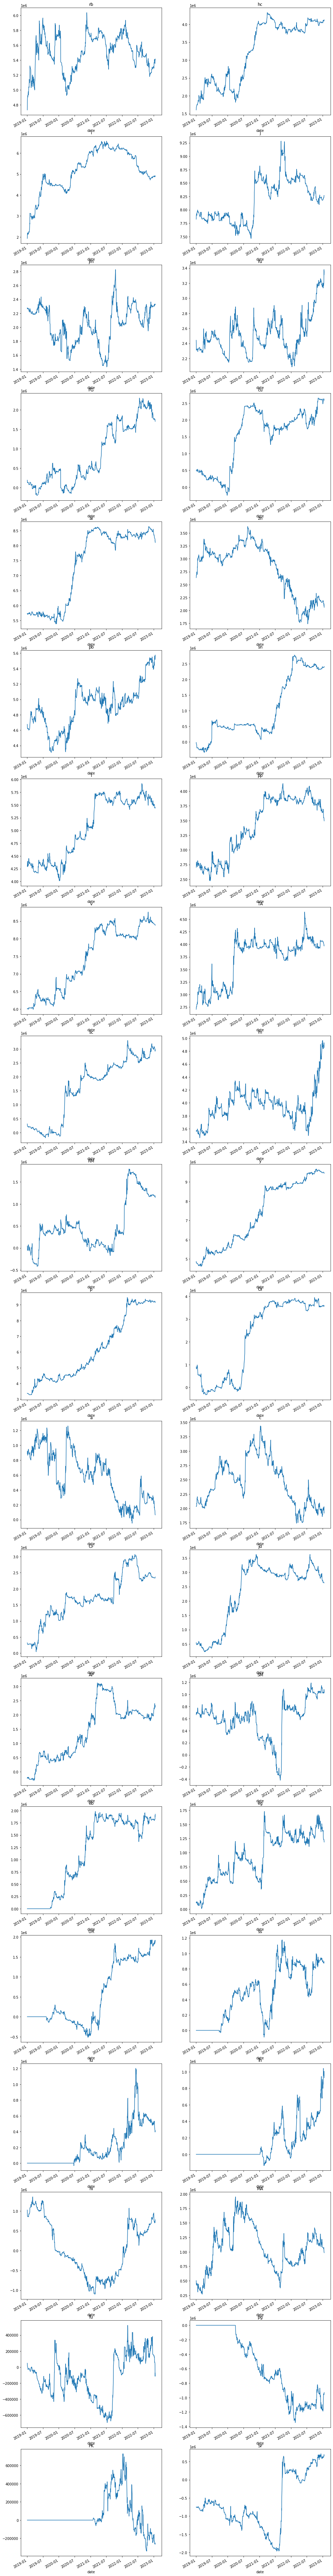

In [26]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2019-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


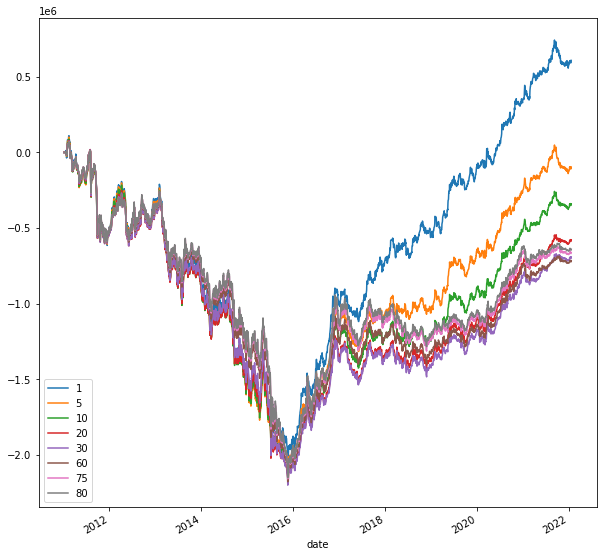

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


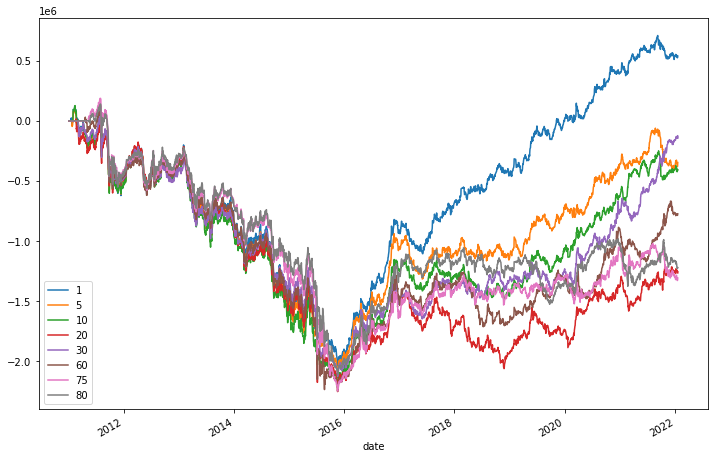

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

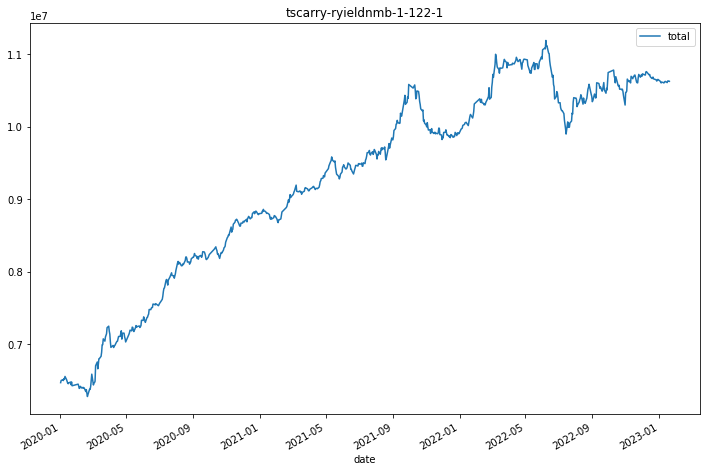

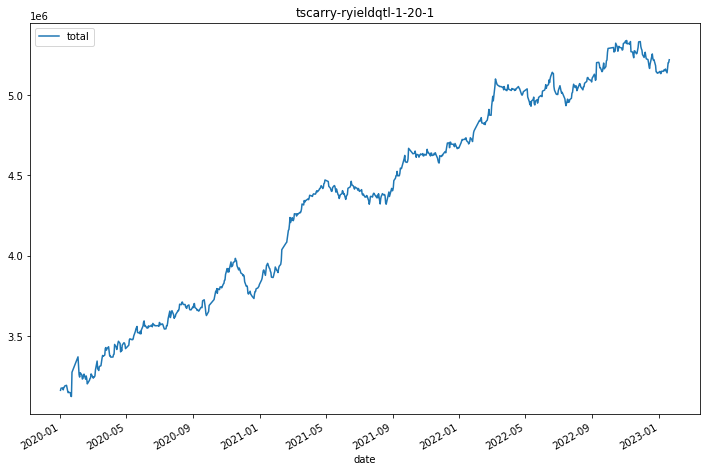

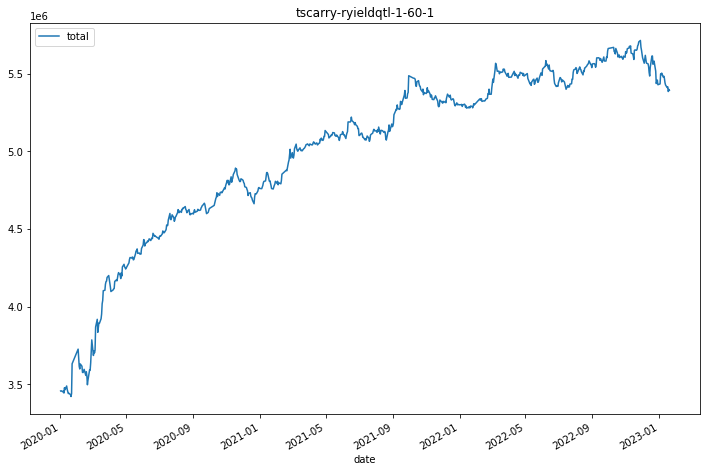

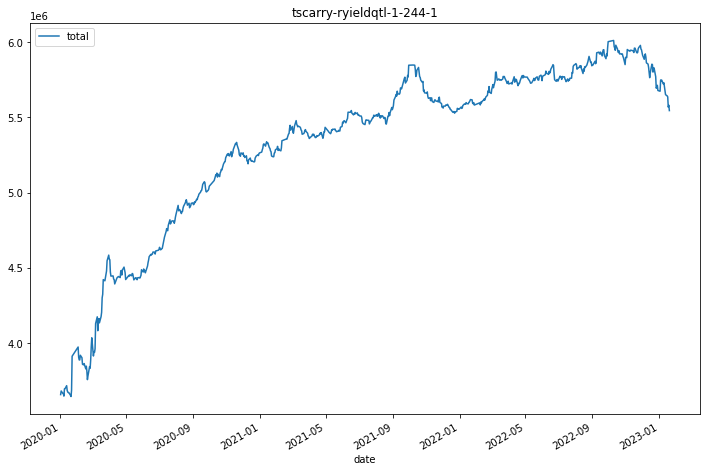

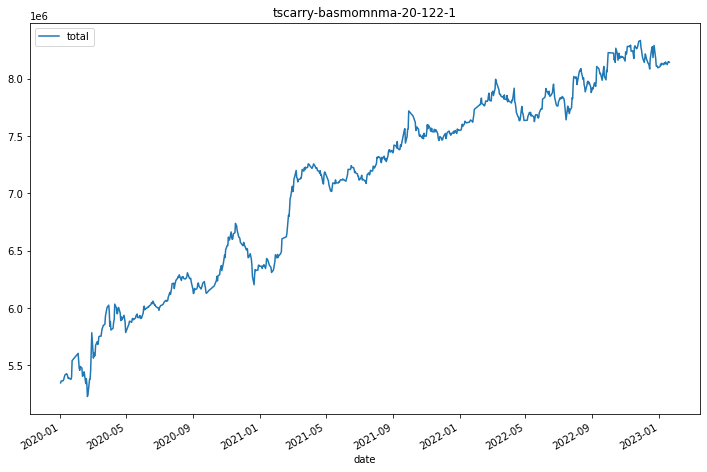

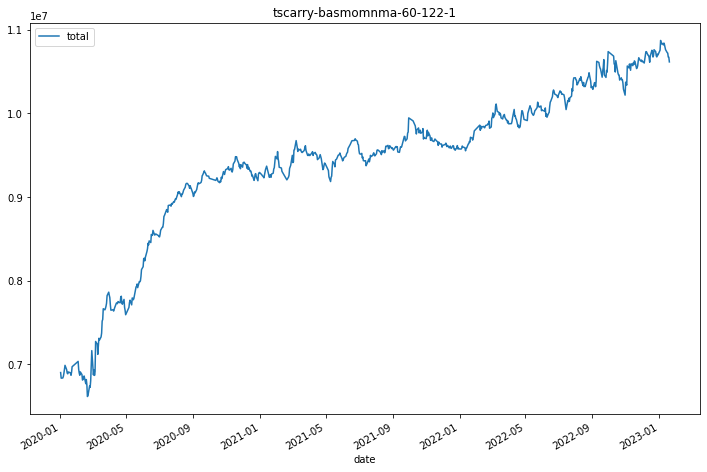

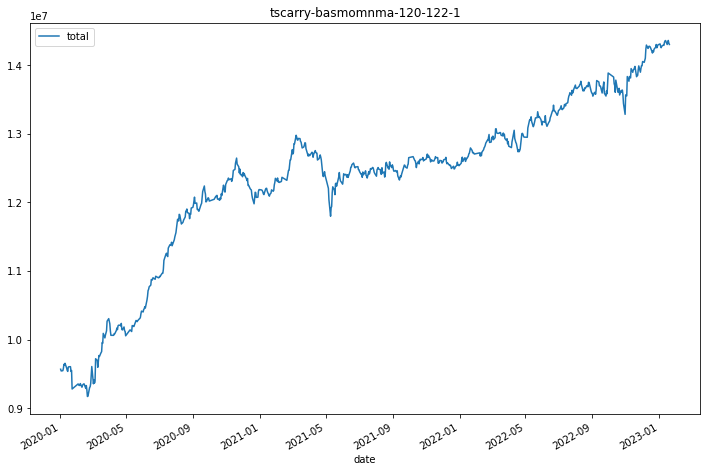

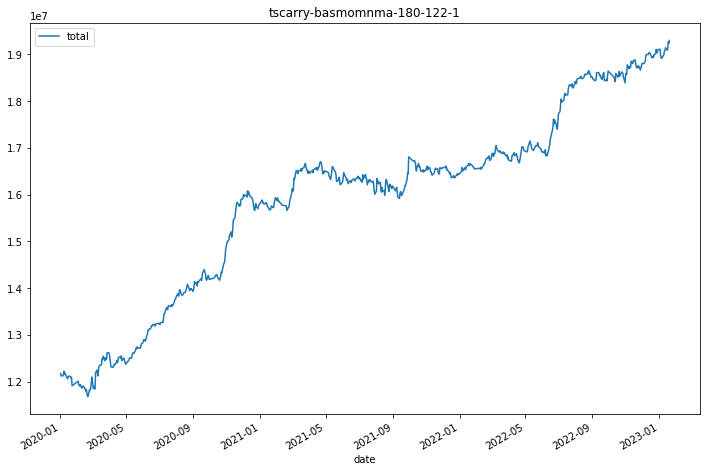

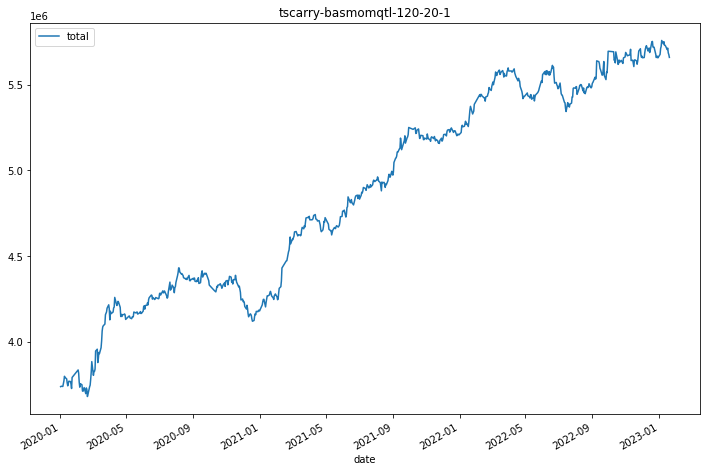

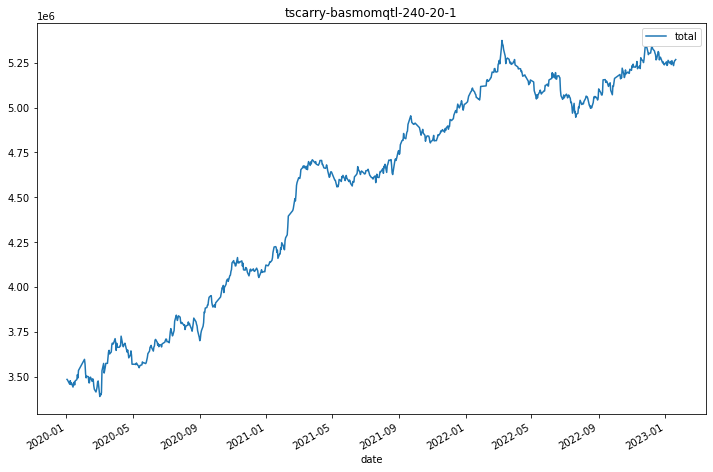

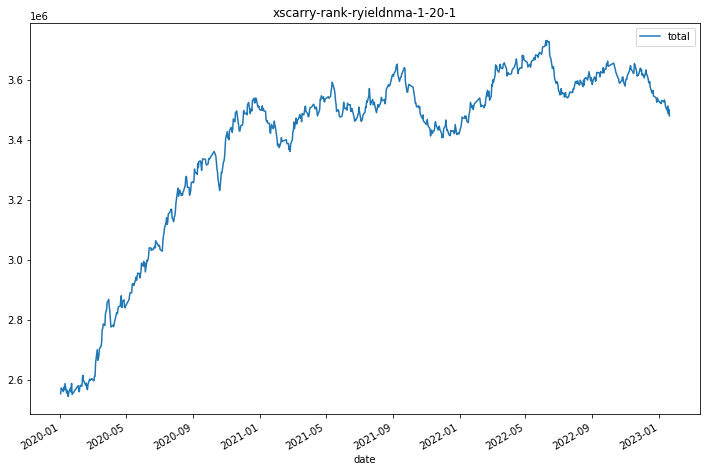

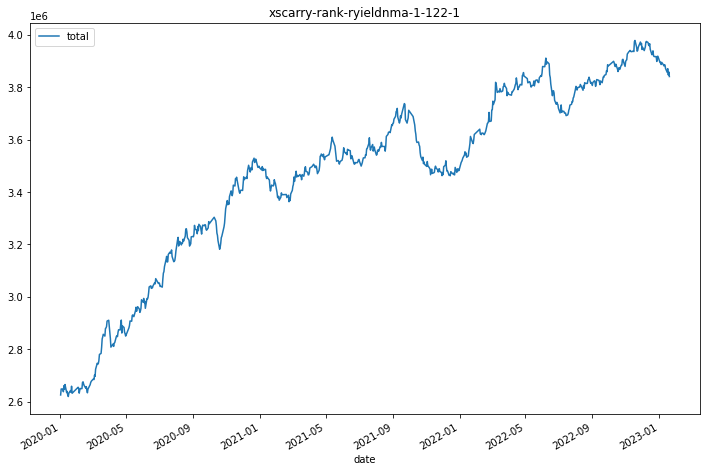

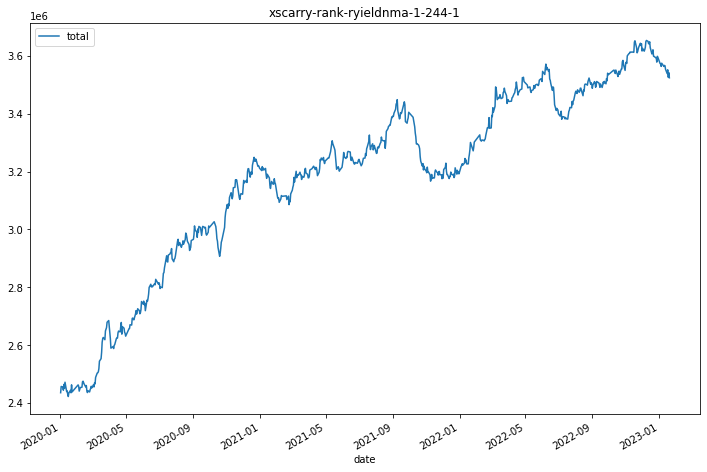

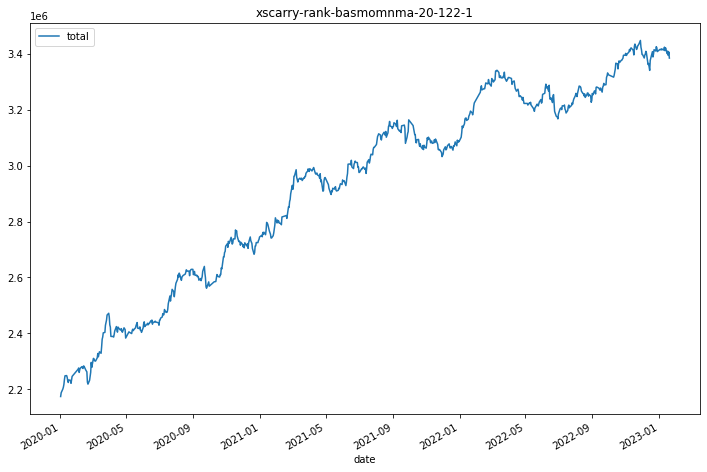

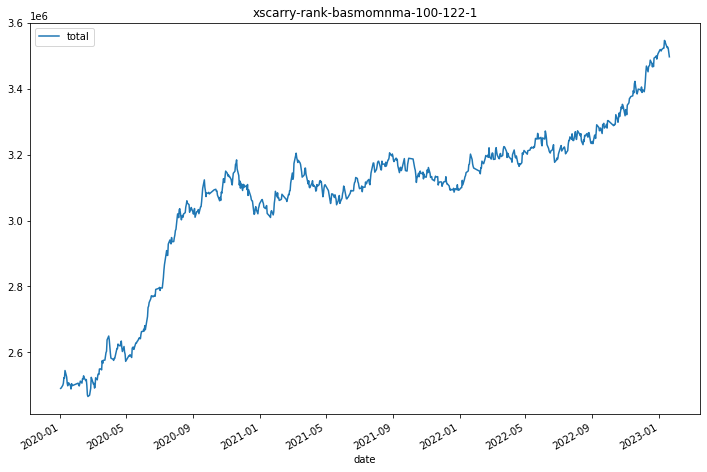

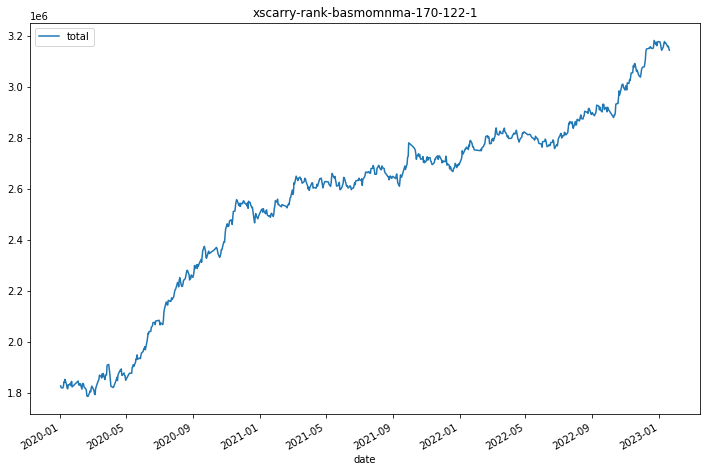

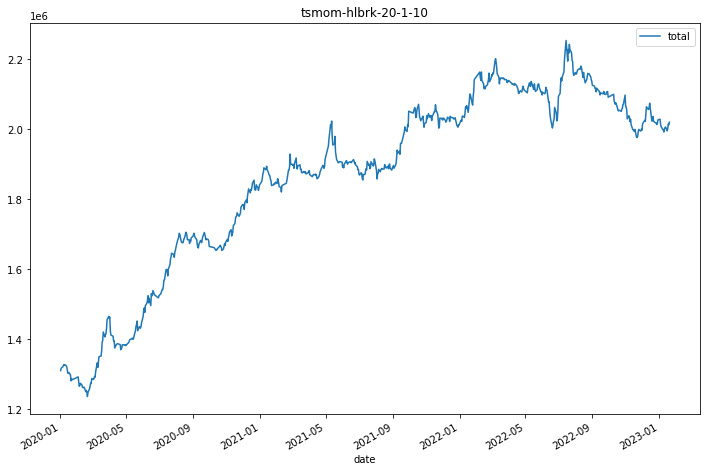

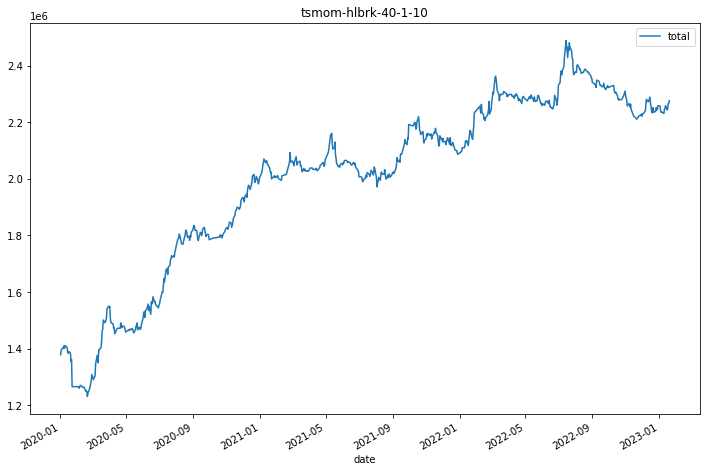

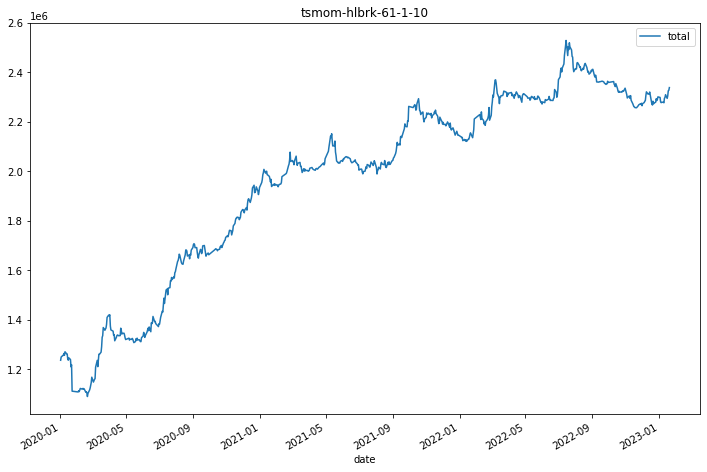

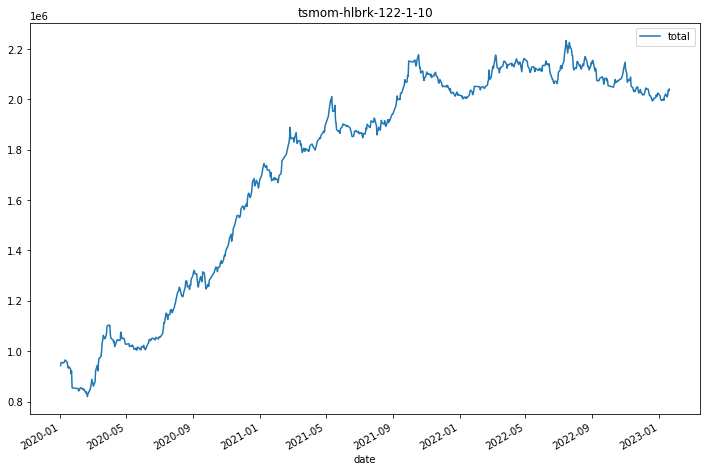

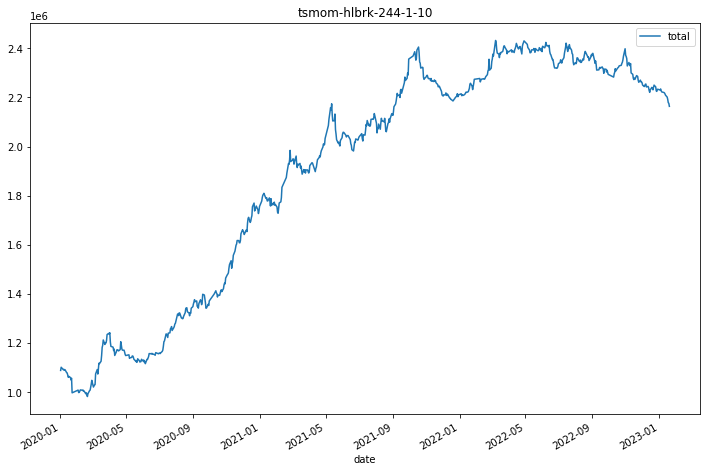

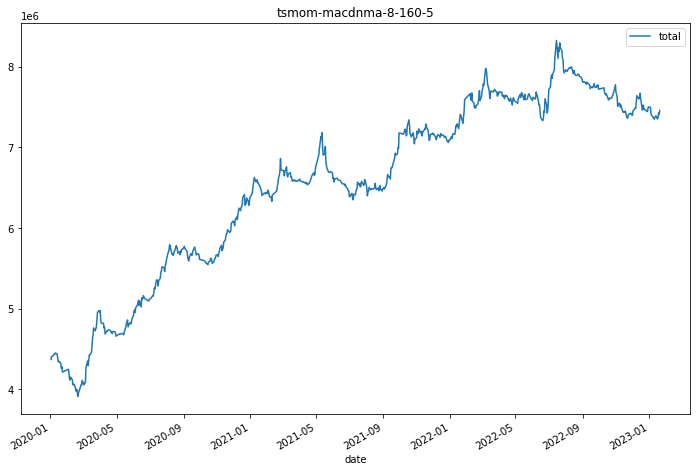

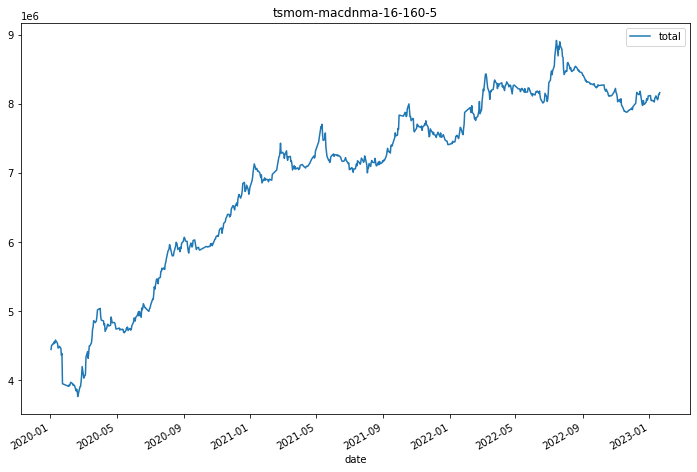

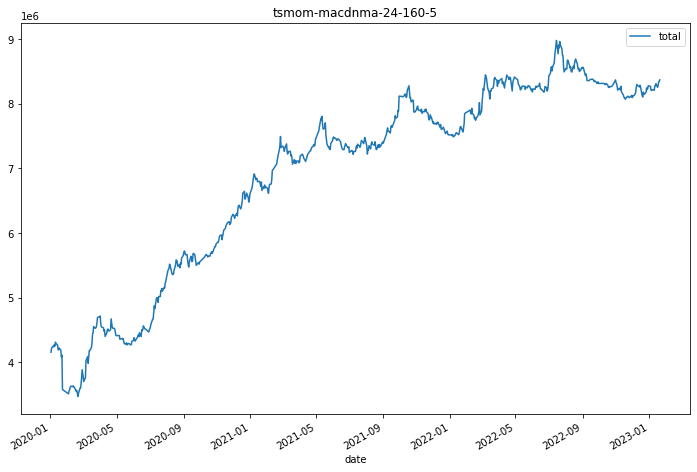

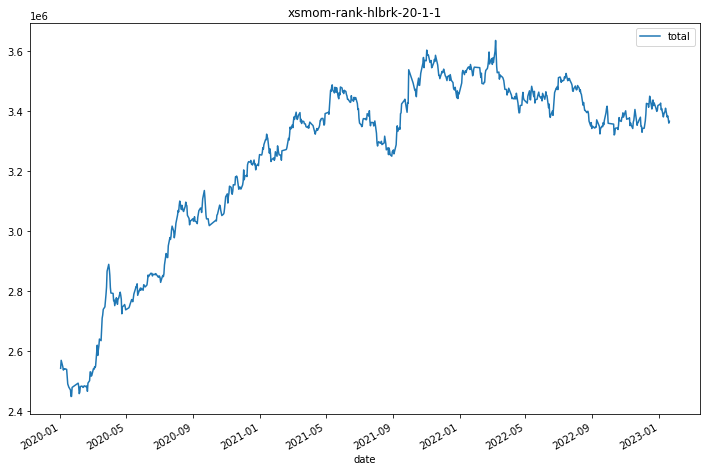

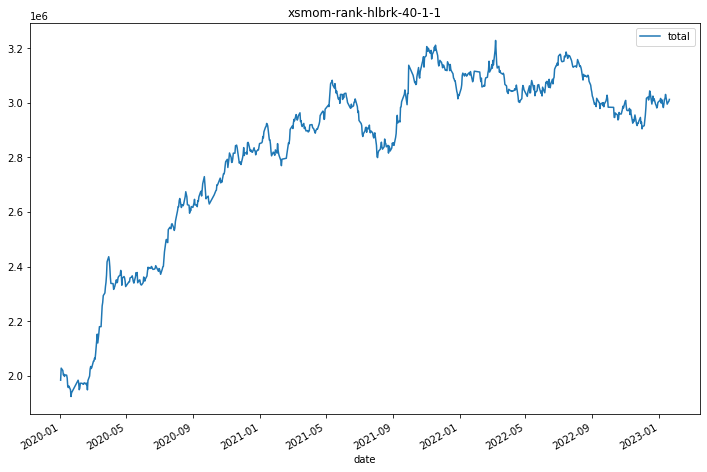

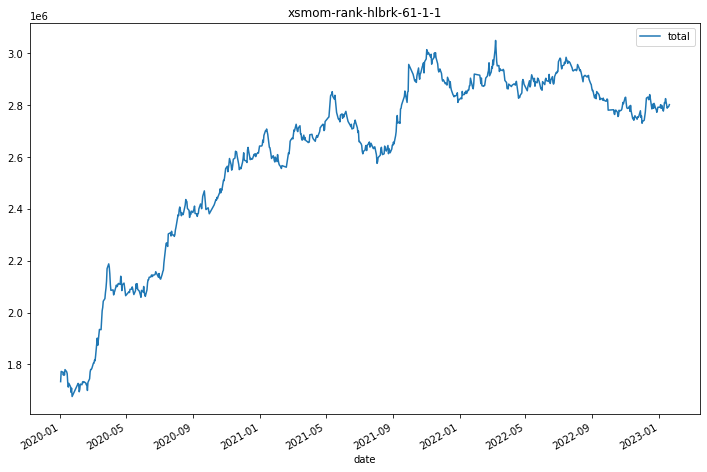

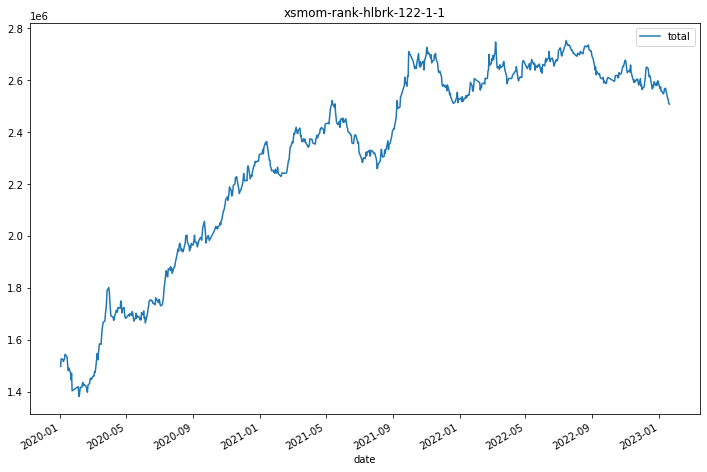

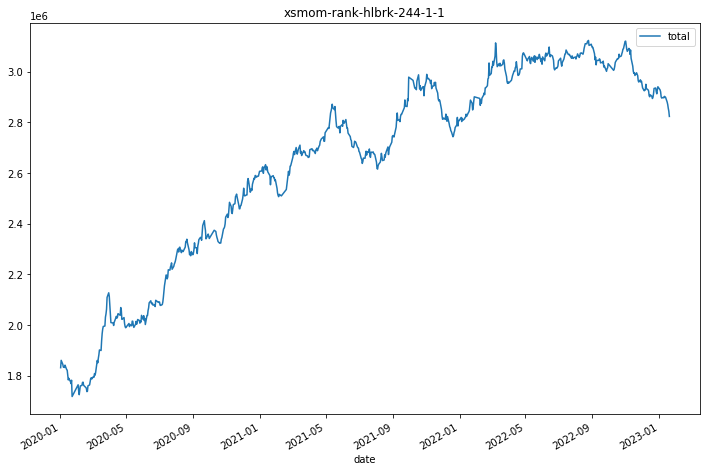

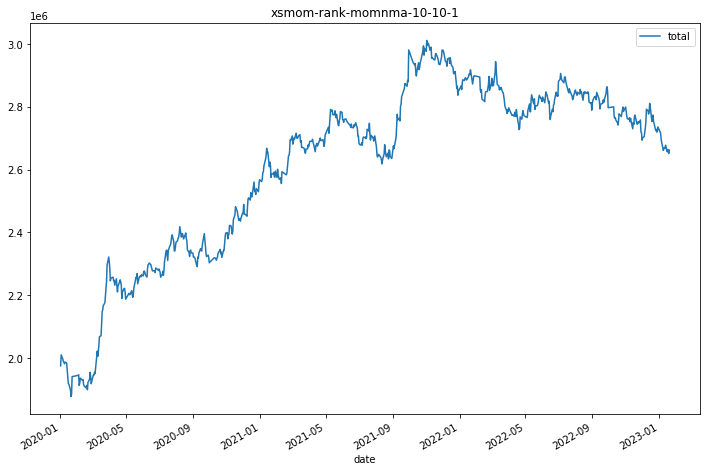

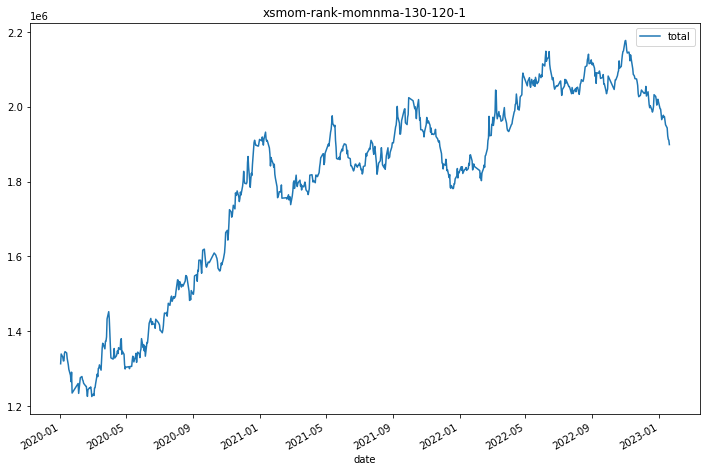

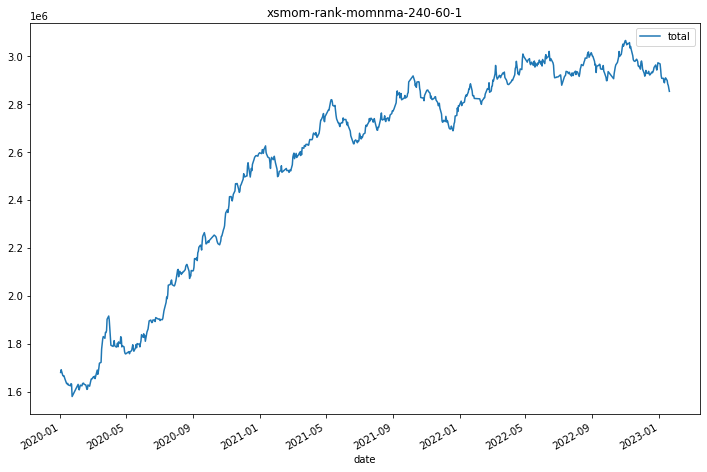

In [46]:
scen_start = pd.to_datetime('2020-01-01')
df_list = []
for scen_name, scen_stat in zip(scen_names, scen_stats):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
